In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
  
# fix relative imports
sys.path.append("..")

import time
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from models import UNet
import utils

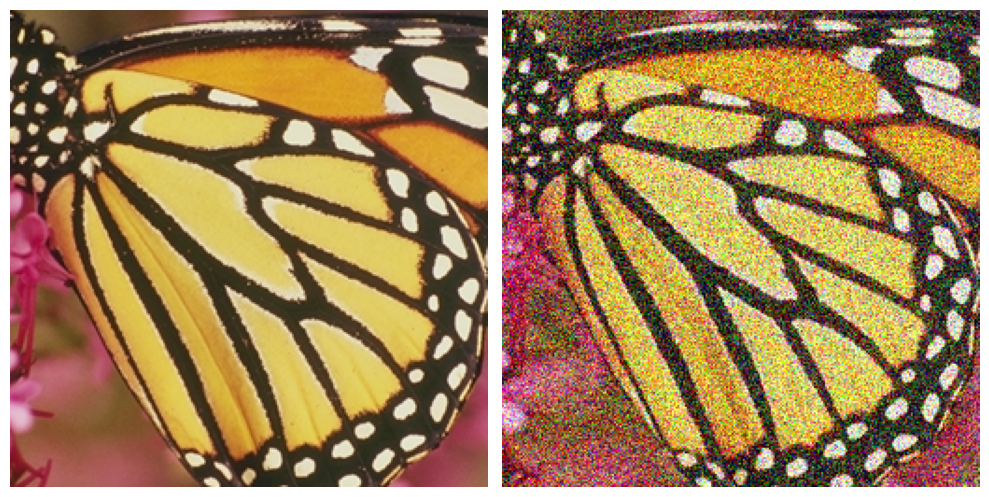

In [42]:
x = utils.load_image('../data/set5/butterfly.png')
# x = utils.load_celeba(1)
x_hat = torch.stack([utils.get_noisy_image(img, 0.2) for img in x])
utils.plot_row([x, x_hat])

In [43]:
input_channels = 3
deep_channels = [8, 16, 32, 64, 128]
skip_channels = [0, 0, 0, 4, 4]

lr = 0.01
window_size = 100
patience = 1000

In [44]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net = UNet(input_channels, deep_channels, skip_channels)
net.to(device)

optimizer = optim.Adam(net.parameters(), lr)
mse = nn.MSELoss()
psnr = PeakSignalNoiseRatio().to(device)

x = x.to(device)
x_hat = x_hat.to(device)

input_shape = [input_channels if i == 1 else s for i, s in enumerate(x_hat.size())]
z = torch.rand(input_shape, device=device) * 0.1  # TODO regularize noise?

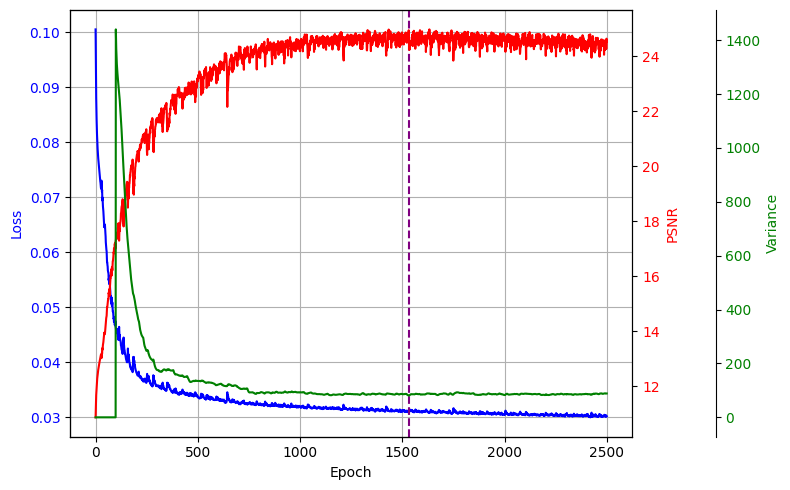

----------
Finished training in 00:02:20



In [45]:
print(f'Training on {device}')
start = time.time()

losses = []
psnrs = []
vars = []

queue = []
x_opt = None
x_2400 = None
var_opt = math.inf
t_opt = 0
t = 0
var = 0
while t - t_opt < patience:
  net.train()
  optimizer.zero_grad()

  out = net(z)
  loss = mse(out, x_hat)
  loss.backward()
  optimizer.step()

  net.eval()

  if t == 2400:
    x_2400 = out.detach().cpu()

  queue.append(out)
  if len(queue) > window_size:
    queue.pop(0)

  if len(queue) == window_size:
    q = torch.stack(queue)
    x_mean = q.mean(dim=0)
    sum = 0
    for x_t in queue:
      # torch.sqrt()?
      sum += torch.sum((x_t - x_mean) ** 2)
    var = (sum / window_size).item()

    if var < var_opt:
      var_opt = var
      t_opt = t
      x_opt = out

  losses.append(loss.item())
  psnrs.append(psnr(out, x).item())
  vars.append(var)

  if t % 100 == 99:
    clear_output(wait=True)
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.grid()

    ax1.plot(losses, 'b-')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(psnrs, 'r-')
    ax2.set_ylabel('PSNR', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(vars, 'g-')
    ax3.set_ylabel('Variance', color='g')
    ax3.tick_params(axis='y', labelcolor='g')

    ax1.axvline(x=t_opt, color='purple', linestyle='--', label=f'Stopping Point')

    fig.tight_layout()
    plt.show()

  t += 1

duration = time.time() - start
print('----------')
print(f'Finished training in {time.strftime('%H:%M:%S', time.gmtime(duration))}\n')

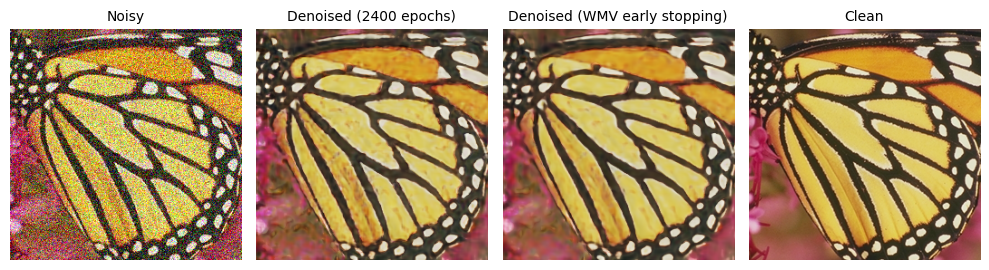

In [48]:
x_opt = x_opt.detach().cpu()
x = x.cpu()
x_hat = x_hat.cpu()

utils.plot_row([x_hat, x_2400, x_opt, x], ['Noisy', 'Denoised (2400 epochs)', 'Denoised (WMV early stopping)', 'Clean'])

In [49]:
ssim = StructuralSimilarityIndexMeasure()
print(f'Noisy: {ssim(x_hat, x)}')
print(f'Denoised (2400): {ssim(x_2400, x)}')
print(f'Denoised (WMV): {ssim(x_opt, x)}')

Noisy: 0.3331187069416046
Denoised (2400): 0.7832918763160706
Denoised (WMV): 0.8127277493476868
